In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class LogisticRegression():
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.__mean = None
        self.__std = None
    
    def get_mean(self):
        return self.__mean
    
    def get_std(self):
        return self.__std
    
    def fit(self, X_vert, Y_vert, alpha, num_iters, epsilon):
        # X transformations
        if self.normalize == True:
            self.X_ = self.__normalize(X_vert)
        else:
            self.X_ = X_vert
        self.X_ = self.X_.T
 
        # Y transformations
        self.Y_ = Y_vert.T

        self.W = np.full(( self.X_.shape[0],self.Y_.shape[0]),0.01)
        self.b = 0.0
        self.W, self.b, self.Js = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, alpha, num_iters, epsilon)

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
    
        y_pred = np.zeros(z.shape[1], dtype=int)
        for i in range(z.shape[1]):
            y_pred[i] = np.argmax(z[:, i])    
        
        return y_pred

    def predict_by_labels(self, X, y_labels):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        
        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
            
        y_pred = np.full((z.shape[1]), {})
        for i in range(z.shape[1]):
            y_pred[i] = { y_labels[j]: z[j][i] for j in range(z.shape[0])}
        return y_pred
            
    def get_cost_history(self):
        check_is_fitted(self)
        return self.Js

    def __normalize(self, X):
        if self.__mean is None and self.__std is None:
            mean = np.zeros([X.shape[1]])
            std  = np.ones([X.shape[1]])
            
            for i in range(X.shape[1]):
                if (np.std(X.iloc[:, i]) != 0):
                    mean[i] = np.mean(X.iloc[:, i])
                    std[i] = np.std(X.iloc[:, i])
            
            self.__mean = mean
            self.__std = std

        X_new = (X - self.__mean) / self.__std
        return X_new

    def __cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def __cross_entropy(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (-1 / m) * np.sum(Y.T * np.log(A.T))
        return J
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)

    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)

    def __forward_backward_propagation(self, X, Y, W, b):        
        # forward propagation
        m = X.shape[1]

        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)
        cost = self.__cross_entropy(X, Y, A)

        # backward propagation
        dz = A - Y
        derivative_weights = (1 / m) * np.dot(X, dz.T)
        derivative_bias = (1 / m) * np.sum(dz)

        return cost, derivative_weights, derivative_bias

    def __gradient_descent(self, X, Y, W, b, alpha, num_iters, epsilon):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]

        J_history = []

        for i in range(num_iters):
            J, delta_weights, delta_bias = self.__forward_backward_propagation(X, Y, W, b)

            W = W - alpha * delta_weights
            b = b - alpha * delta_bias

            if i % 100 == 0:
                print(f"{i} iteration: {J}")

            J_history.append(J)

        return W, b, J_history

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class AttackTFGSM():
    # Fast Gradient Sign Method Attack
    def __init__(self, normalize=False):
        self.goal_assurance_history = []
        self.__std = None
        self.__mean = None

    def fit(self, X_vert, W, b, Y_vert, alpha, max_iters, predict_func):
        # Check that X and y have correct shape        
        self.num_iters = 0
        self.max_iters = max_iters
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert.T, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, alpha, predict_func)    
            
    # def get_adversarial_X(self):
    #     if (not self.std is None) and (not self.mean is None):
    #         return (self.X_ * self.std) + self.mean

    def __cross_entropy(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (-1 / m) * np.sum(Y.T * np.log(A.T))
        return J
    
    def __softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / exp_z.sum(axis=0, keepdims=True)
    
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __forward_backward_propagation(self, X, Y, W, b):
        # forward propagation
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)

        # backward propagation
        dz = A - Y
        derivative_x = (1 / m) * np.dot(W, dz)
        return derivative_x

    def __is_tricked_with_goal(self, X, Y, predict_func):
        # goal class position
        goal_pos = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] != goal_pos):
            return False
        return True

    def __gradient_descent(self, X, Y, W, b, alpha, predict_func):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]
        
        while (not self.__is_tricked_with_goal(X.T, Y, predict_func)) and (self.num_iters < self.max_iters):
            delta_x = self.__forward_backward_propagation(X, Y, W, b)
            X = X + alpha * np.sign(delta_x)
            
            self.num_iters += 1       
        
        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
            
        X_vert = X.T
        return X_vert

In [90]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class AttackFGSM():
    # Fast Gradient Sign Method Attack
    def __init__(self, normalize=False):
        self.goal_assurance_history = []
        self.__std = None
        self.__mean = None

    def fit(self, X_vert, W, b, Y_vert_true, max_perturbation, max_iters, predict_func):
        self.num_iters = 0
        self.max_iters = max_iters
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, max_perturbation, predict_func)                

    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __forward_backward_propagation(self, X, Y, W, b):
        # forward propagation
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)

        # backward propagation
        #print(A)
        #print(Y)
        dz = A - Y
        derivative_x = (1 / m) * np.dot(W, dz)
        return derivative_x

    def __is_tricked(self, X, Y, predict_func):
        # goal class position
        true_class = np.argmax(Y[:, 0] != 0)
        #print(predict_func(np.array(X))[0])
        #print(true_class)
        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True

    def __gradient_descent(self, X, Y, W, b, max_perturbation, predict_func):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]
        
        #while (not self.__is_tricked(X.T, Y, predict_func)) and (self.num_iters < self.max_iters):
        alpha = int(max_perturbation / self.max_iters)
        
        for i in range(self.max_iters):
            delta_x = self.__forward_backward_propagation(X, Y, W, b)
            X = X + alpha * np.sign(delta_x)
            
            X[X > 255] = 255
            X[X < 0] = 0

            self.num_iters += 1
            
            if self.__is_tricked(X.T, Y, predict_func) == True:
                break
                
        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
            
        X_vert = X.T
        return X_vert

In [6]:
filename_test = "./digit-recognizer/test.csv"
filename_train = "./digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


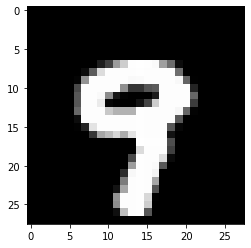

In [8]:
X_t =  X_train.values.reshape(-1,28,28,1)
g = plt.imshow(X_t[0][:, :, 0], 'gray')

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)

Y_train = encoder.transform(y_train).toarray()
y_labels = [x[3:] for x in  encoder.get_feature_names()]

# encoder.fit(y_test)
# Y_test = encoder.transform(y_test).toarray()

0 iteration: 98.68221827117337
100 iteration: 10.527635029217327
200 iteration: 9.85683711543259
300 iteration: 9.488991781217527
400 iteration: 9.234389431131184
500 iteration: 9.039853774009835
600 iteration: 8.882803867671234
700 iteration: 8.75145137665818
800 iteration: 8.638825317088621
900 iteration: 8.54044947559529


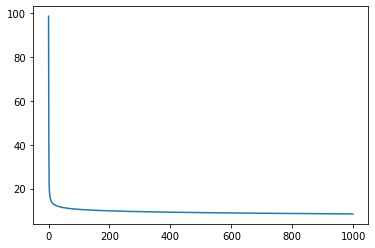

8.454102541447872


In [10]:
lg = LogisticRegression(normalize=True)
lg.fit(X_train, Y_train, 1, 1000, 1e-20)

plot_J(lg.get_cost_history())
print(lg.get_cost_history()[-1])

In [11]:
y_pred = lg.predict(X_test)
y_pred

array([9, 4, 3, ..., 6, 3, 4])

In [82]:
from matplotlib import rc
def show_adversarial_sample(x, y_labels, max_perturbation, num_iter, goal=[], model=lg):
    attack = AttackFGSM()
    attack.fit(x, lg.W, lg.b, goal, max_perturbation, num_iter, lg.predict)
    adv_pred = lg.predict(np.array( attack.X_))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, sharex=True, sharey=True)
    fig.set_size_inches(15,5)
    fig.suptitle('Adversarial example')
    
    ax1.imshow(x.reshape(28,28), 'gray')
    ax1.set_title(f"Original\n prediction: {lg.predict(x)[0]}")
    
    ax2.imshow(x.reshape(28,28) - attack.X_.reshape(28,28), "gray")
    ax2.set_title(f"Difference")
    
    ax3.imshow(attack.X_.reshape(28,28), 'gray')
    ax3.set_title(f"Adversarial\n prediction: {adv_pred[0]}")

    plt.show()

    pred_full = lg.predict_by_labels(np.array( attack.X_), y_labels)
    plt.bar(pred_full[0].keys(), pred_full[0].values())
    plot_J(attack.goal_assurance_history)
    plt.show()
    print(f"Iterations: {attack.num_iters}; alpha: {alpha};")
    print(max(max(attack.X_)))
    print(min(min(attack.X_)))

In [13]:
def get_trick_iteration(x, y_labels, num_iter, alpha, goal=[], model=lg):
    attack = AttackFGSM(normalize=True)
    attack.fit(x, lg.W, lg.b, goal, alpha, num_iter, lg.predict)
    adv_pred = lg.predict(np.array( attack.X_))
    return attack.num_iters, attack.tricked

In [14]:
n = len(y_labels)

5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12
5
12


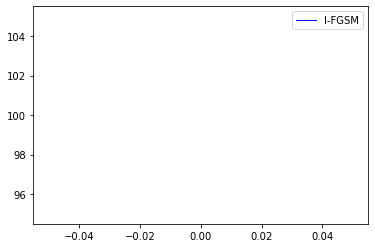

In [15]:
X_test_norm = (X_test - lg.get_mean()) / lg.get_std()

num = 0
den = 0
iter_res_dict = {}
y = np.zeros(n)



for i in range(10):
    x = np.expand_dims(X_test_norm.iloc[i, :], axis=0)
    for j in range(len(y_labels)):
        y = np.zeros(n)
        y[j] = 1
        for k in range(100):
            iters, result  = get_trick_iteration(x, y_labels, k, 0.01, goal=y, model=lg)
            #if (iters == 10):
            #    print(i, y)
            if iters in iter_res_dict.keys():
                iter_res_dict[iters]["appearance_count"] += 1 
                iter_res_dict[iters]["success_count"] += result

            else:
                iter_res_dict.update({iters: {"appearance_count": 1, "success_count": result} })
    
success_rate = {}
for key, value in iter_res_dict.items():
    success_rate[key] = value["success_count"] / value["appearance_count"] * 100
        
#print(num / den)
#print(iter_res_dict)
#print(success_rate)

line1, = plt.plot(list(success_rate.keys()), list(success_rate.values()), linestyle='-', linewidth=1, color='blue', label='I-FGSM')
plt.legend(loc="upper right")


{1: 100.0, 3: 100.0}


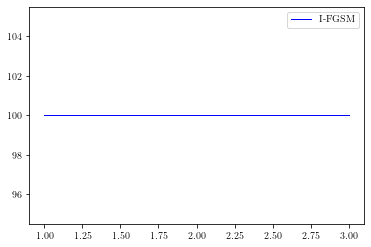

In [93]:
X_test_norm = (X_test - lg.get_mean()) / lg.get_std()

num = 0
den = 0
iter_res_dict = {}
y = np.zeros(n)



for i in range(100):
    x = np.expand_dims(X_test_norm.iloc[i, :], axis=0)
    y = np.zeros(n)
    true_class_pos = lg.predict(x)
    y[true_class_pos] = 1
    #print(true_class_pos)
    iters, result  = get_trick_iteration(x, y_labels, 20, 20, goal=y, model=lg)
    if (iters == 10):
        print(i, y)

    if iters in iter_res_dict.keys():
        iter_res_dict[iters]["appearance_count"] += 1 
        iter_res_dict[iters]["success_count"] += result
    else:
        iter_res_dict.update({iters: {"appearance_count": 1, "success_count": result} })
    
success_rate = {}
for key, value in iter_res_dict.items():
    success_rate[key] = value["success_count"] / value["appearance_count"] * 100
        
#print(num / den)
#print(iter_res_dict)
print(success_rate)
plt.plot(list(success_rate.keys()), list(success_rate.values()), linestyle='-', linewidth=1, color='blue', label='I-FGSM')
plt.legend(loc="upper right")


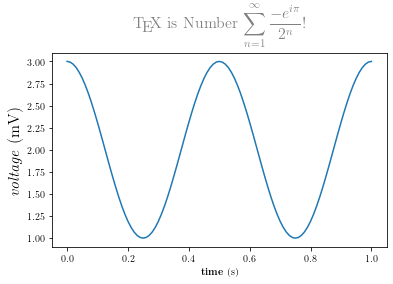

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


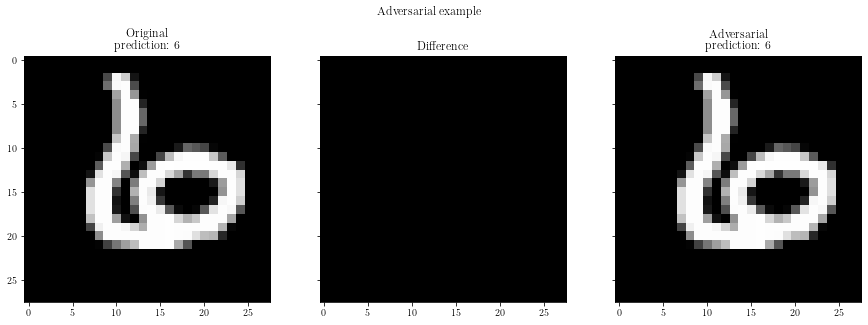

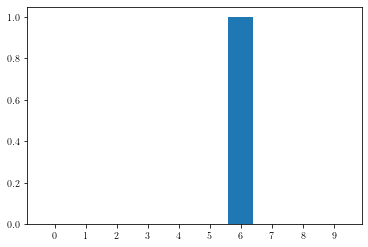

Iterations: 1; alpha: 1;
255.0
0.0


In [62]:
index = 623
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(n)
true_class_pos = lg.predict(x)
y[true_class_pos] = 1
print(y)

show_adversarial_sample(x, y_labels, 1, 1, goal=y, model=lg)

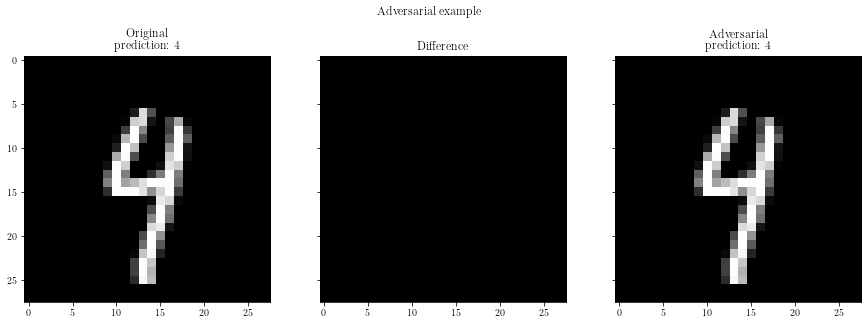

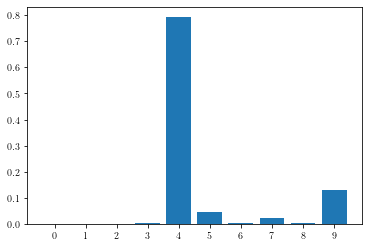

Iterations: 0; alpha: 1;
255
0


In [45]:
y = np.zeros(n)
y[8] = 1
index = 100
x = np.expand_dims(X_test.iloc[index, :], axis=0)

show_adversarial_sample(x, y_labels, 1000, 1, goal=y, model=lg)

In [20]:
y_real = np.array(y_test.iloc[:, 0])

comp = pd.DataFrame({"y_pred": y_pred, "y_real": y_real})
print(comp.head(20))

    y_pred  y_real
0        9       9
1        4       4
2        3       3
3        8       3
4        1       1
5        2       5
6        2       3
7        6       6
8        8       8
9        2       2
10       1       1
11       9       9
12       8       8
13       1       1
14       4       4
15       1       1
16       3       3
17       3       3
18       8       8
19       2       2


In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
rmse = mean_squared_error(y_real, y_pred, squared=True)
mse = mean_squared_error(y_real, y_pred, squared=False)
mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)
accuracy = int(sum(y_real == y_pred) / len(y_pred) * 100)


#print(f'Coefficients\n {theta}')
print(f'Root mean squared error: {rmse}')
print(f'Mean squared error: {mse}')
print(f'Mean absolute error: {mae}')
print(f'Coefficient of determination: {r2}')
print(f"Accuracy: {accuracy}%")

Root mean squared error: 1.4854761904761904
Mean squared error: 1.2188011283536746
Mean absolute error: 0.32095238095238093
Coefficient of determination: 0.8219164292631354
Accuracy: 90%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Example data
t = np.arange(0.0, 1.0 + 0.01, 0.01)
s = np.cos(4 * np.pi * t) + 2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(t, s)

plt.xlabel(r'\textbf{time} (s)')
plt.ylabel(r'\textit{voltage} (mV)',fontsize=16)
plt.title(r"\TeX\ is Number "
          r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
          fontsize=16, color='gray')
# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)

# plt.savefig('tex_demo')
# plt.show()